# EE16A: Homework 2

## Problem 6: Image Stitching

This section of the notebook continues the image stiching problem. Be sure to have a `figures` folder in the same directory as the notebook. The `figures` folder should contain the files:

    Berkeley_banner_1.jpg
    Berkeley_banner_2.jpg
    stacked_pieces.jpg
    lefthalfpic.jpg
    righthalfpic.jpg
    
Note: This structure is present in the provided HW2 zip file.

Run the next block of code before proceeding


In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi, cos, exp, sin
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms


%matplotlib inline

#loading images
image1=mpimg.imread('figures/Berkeley_banner_1.jpg')
image1=image1/255.0
image2=mpimg.imread('figures/Berkeley_banner_2.jpg')
image2=image2/255.0
image_stack=mpimg.imread('figures/stacked_pieces.jpg')
image_stack=image_stack/255.0


image1_marked=mpimg.imread('figures/lefthalfpic.jpg')
image1_marked=image1_marked/255.0
image2_marked=mpimg.imread('figures/righthalfpic.jpg')
image2_marked=image2_marked/255.0

def euclidean_transform_2to1(transform_mat,translation,image,position,LL,UL):
    new_position=np.round(transform_mat.dot(position)+translation)
    new_position=new_position.astype(int)

    
    if (new_position>=LL).all() and (new_position<UL).all():
        values=image[new_position[0][0],new_position[1][0],:]
    else:
        values=np.array([2.0,2.0,2.0])
    
    return values

def euclidean_transform_1to2(transform_mat,translation,image,position,LL,UL):
    transform_mat_inv=np.linalg.inv(transform_mat)
    new_position=np.round(transform_mat_inv.dot(position-translation))
    new_position=new_position.astype(int)
    
    if (new_position>=LL).all() and (new_position<UL).all():
        values=image[new_position[0][0],new_position[1][0],:]
    else:
        values=np.array([2.0,2.0,2.0])
    
    return values

We will stick to a simple example and just consider stitching two images (if you can stitch two pictures, then you could conceivably stitch more by applying the same technique over and over again).

Daniel decided to take an amazing picture of the Campanile overlooking the bay. Unfortunately, the field of view of his camera was not large enough to capture the entire scene, so he decided to take two pictues and stich them together. 

The next block will display the two images.

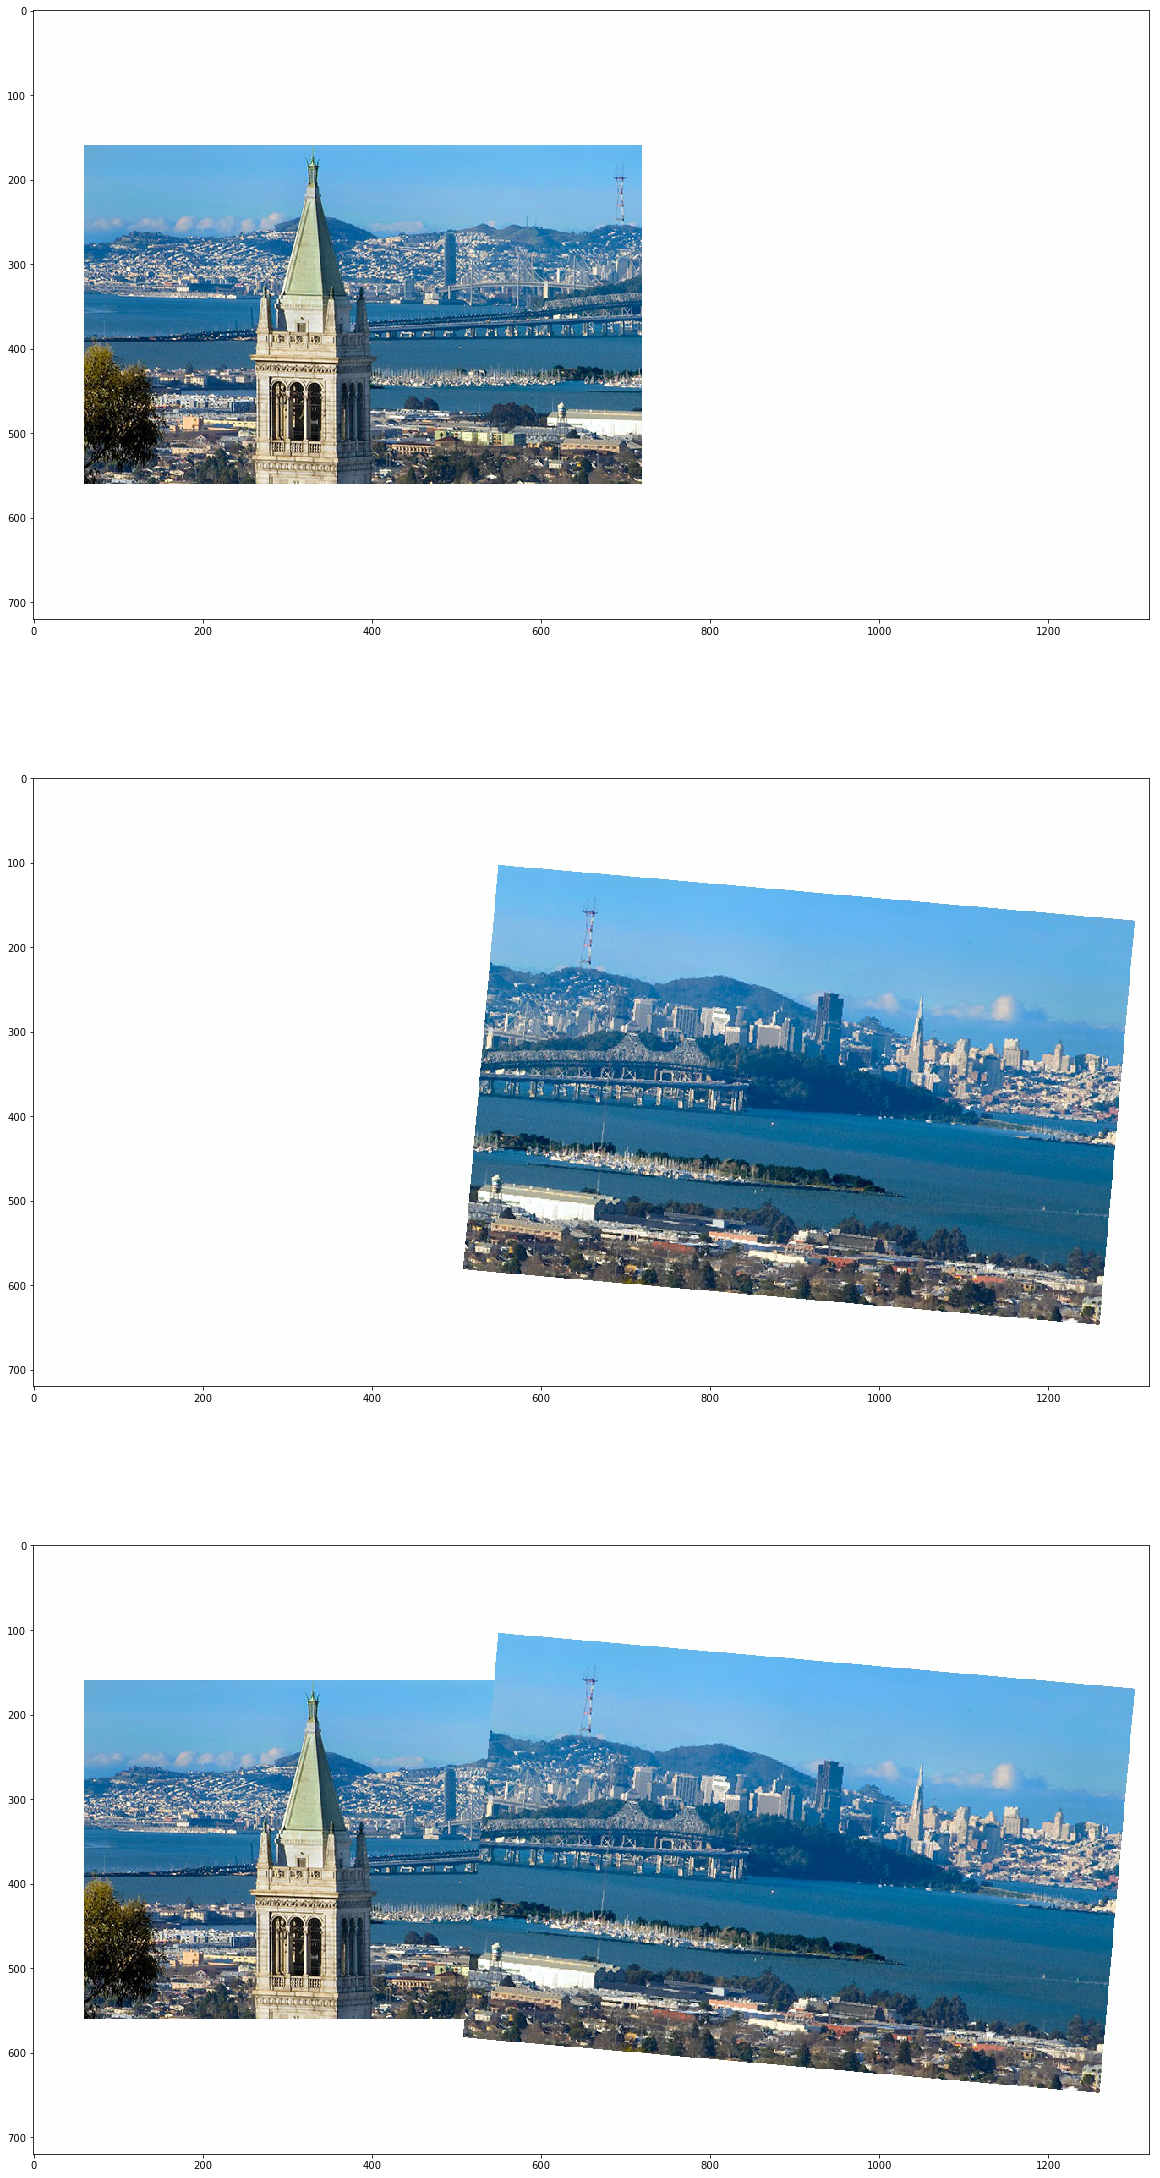

In [3]:
plt.figure(figsize=(20,40))

plt.subplot(311)
plt.imshow(image1)

plt.subplot(312)
plt.imshow(image2)

plt.subplot(313)
plt.imshow(image_stack)

plt.show() 

Once you apply Marcela's algorithm on the two images you get the following result (run the next block):

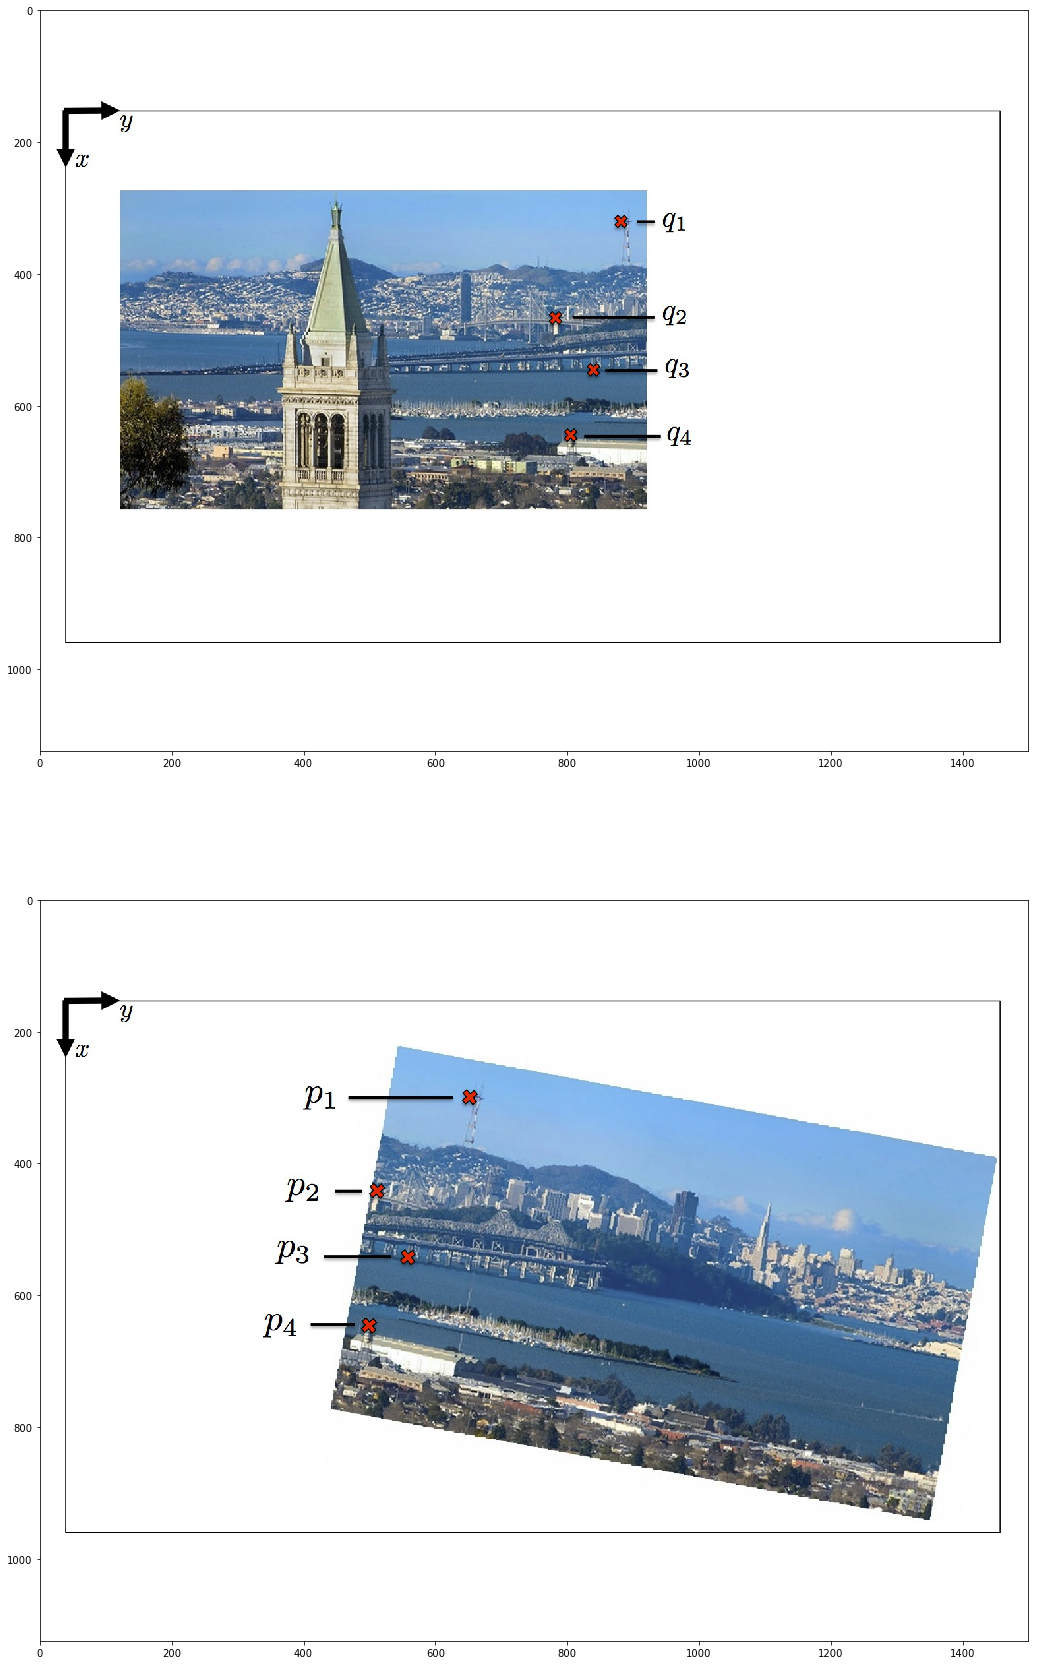

In [4]:
plt.figure(figsize=(20,30))

plt.subplot(211)
plt.imshow(image1_marked)

plt.subplot(212)
plt.imshow(image2_marked)

As you can see Marcela's algorithm was able to find four common points between the two images. These points expressed in the coordinates of the first image and second image are

$\begin{align} 
&&\vec{p_1}=\begin{bmatrix} 200 \\ 700 \end{bmatrix}
&&\vec{p_2}=\begin{bmatrix} 310 \\ 620 \end{bmatrix} 
&&\vec{p_3}=\begin{bmatrix} 390 \\ 660 \end{bmatrix}
&&\vec{p_4}=\begin{bmatrix} 460 \\ 630 \end{bmatrix}\\
&&\vec{q_1}=\begin{bmatrix} 162.2976 \\ 565.8862 \end{bmatrix}
&&\vec{q_2}=\begin{bmatrix} 285.4283 \\ 458.7469 \end{bmatrix} 
&&\vec{q_3}=\begin{bmatrix} 385.2465 \\ 498.1973 \end{bmatrix}
&&\vec{q_4}=\begin{bmatrix} 465.7892 \\ 455.0132 \end{bmatrix}
\end{align}$

It should be noted that in relation to the image the positive x-axis is down and the positive y-axis is right. This will have no bearing as to how you solve the problem, however it helps in interpreting what the numbers mean relative to the image you are seeing.

Using the points determine the parameters $R_{11},R_{12},R_{21},R_{22},T_x,T_y$ that map the points from the first image to the points in the second image by solving an appropriate system of equations. Hint: you do not need all the points to recover the parameters. 

In [5]:
# Note that the following is a general template for solving for 6 unknowns from 6 equations represented as Az = b.
# You do not have to use the following code exactly. 
# All you need to do is to find parameters R_11, R_12, R_21, R_22, T_x, T_y. 
# If you prefer finding them another way it is fine.

# fill in the entries
A = np.array([[200,700,0,0,1,0],
              [0,0,200,700,0,1],
              [310,620,0,0,1,0],
              [0,0,310,620,0,1],
              [390,660,0,0,1,0],
              [0,0,390,660,0,1]])

# fill in the entries
b = np.array([[162.2976],[565.8862],[285.4283],[458.7469],[385.2465],[498.1973]])

A = A.astype(float)
b = b.astype(float)

# solve the linear system for the coefficiens
z = np.linalg.solve(A,b)

#Parameters for our transformation
R_11 = z[0,0]
R_12 = z[1,0]
R_21 = z[2,0]
R_22 = z[3,0]
T_x  = z[4,0]
T_y  = z[5,0]


Stitch the images using the transformation you found by running the code below.

### Note that it takes about 40 seconds for the block to finish running on a modern laptop.



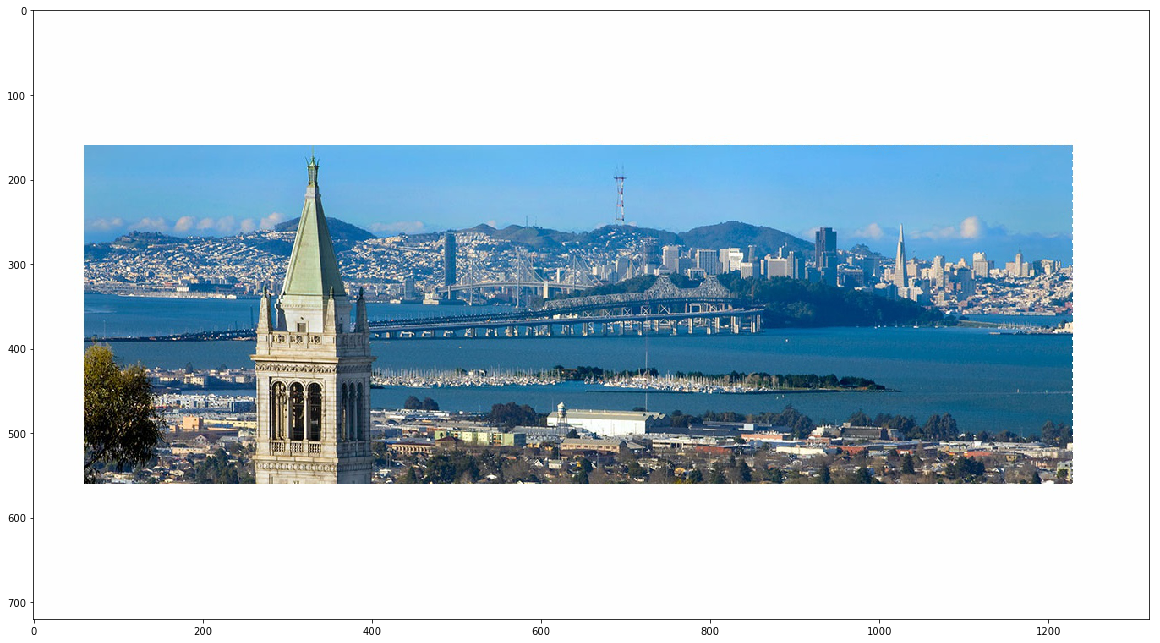

In [6]:
matrix_transform=np.array([[R_11,R_12],[R_21,R_22]])
translation=np.array([T_x,T_y])

#Creating image canvas (the image will be constructed on this)
num_row,num_col,blah=image1.shape
image_rec=1.0*np.ones((int(num_row),int(num_col),3))

#Reconstructing the original image

LL=np.array([[0],[0]]) #lower limit on image domain
UL=np.array([[num_row],[num_col]]) #upper limit on image domain

for row in range(0,int(num_row)):
    for col in range(0,int(num_col)):
        #notice that the position is in terms of x and y, so the c  
        position=np.array([[row],[col]])       
        if image1[row,col,0] > 0.995 and image1[row,col,1] > 0.995 and image1[row,col,2] > 0.995:
            temp = euclidean_transform_2to1(matrix_transform,translation,image2,position,LL,UL)
            image_rec[row,col,:] = temp
        else:
            image_rec[row,col,:] = image1[row,col,:]
        

plt.figure(figsize=(20,20))
plt.imshow(image_rec)
plt.axis('on')
plt.show()

## Problem 8: Bieber's Segway

Run the following block of code first to get all the dependencies.

In [7]:
# %load gauss_elim.py
from gauss_elim import gauss_elim

In [8]:
from numpy import zeros, cos, sin, arange, around, hstack
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import numpy as np
from scipy.interpolate import interp1d
import scipy as sp

## Dynamics

In [9]:
# Dynamics: state to state
A = np.array([[1, 0.05, -.01, 0],
              [0, 0.22, -.17, -.01],
              [0, 0.1, 1.14, 0.10],
              [0, 1.66, 2.85, 1.14]]);
# Control to state
b = np.array([.01, .21, -.03, -0.44])
nr_states = b.shape[0]

# Initial state
state0 = np.array([-0.3853493, 6.1032227, 0.8120005, -14])

# Final (terminal state)
stateFinal = np.array([0, 0, 0, 0])

## Part (d), (e), (f)

In [10]:
# You may use gauss_elim to help you find the row reduced echelon form.
Ab = np.dot(A,b)
mAx = -np.dot((np.dot(A,A)),state0)
print(Ab)
print(mAx)
Matrix = ([[0.0208, 0.01, 0.02243475],
           [0.0557, 0.21, -0.30785117],
           [-0.0572, -0.03, 0.06193476],
           [-0.2385, -0.44, 1.38671326]])
np.linalg.matrix_rank(Matrix)

[ 0.0208  0.0557 -0.0572 -0.2385]
[ 0.02243475 -0.30785117  0.06193476  1.38671326]


3

In [11]:
A2b = np.dot(np.dot(A,A),b)
A2 = np.dot(A,A)
A3 = np.dot(A2,A)
A3x = -np.dot(A3,state0)
print(A2b)
print(A3x)
Matrix2 = ([[0.024157, 0.0208, 0.01, 0.00642285],
            [0.024363, 0.0557, 0.21, -0.0921233],
            [-0.083488, -0.0572, -0.03, 0.17849184],
            [-0.342448, -0.2385, -0.44, 1.24633424]])
np.linalg.matrix_rank(Matrix2)

[ 0.024157  0.024363 -0.083488 -0.342448]
[ 0.00642285 -0.0921233   0.17849184  1.24633424]


4

In [12]:
A3b = np.dot(A3,b)
A4 = np.dot(A3,A)
A4x = -np.dot(A4,state0)
print(A3b)
print(A4x)
Matrix3 = ([[0.02621003, 0.024157, 0.0208, 0.01],
            [0.0229773, 0.024363, 0.0557, 0.21],
            [-0.12698482, -0.083488, -0.0572, -0.03],
            [-0.58788894, -0.342448, -0.2385, -0.44]])
print(np.linalg.matrix_rank(Matrix3))
result = np.linalg.solve(Matrix3, A4x)
print(result)

[ 0.02621003  0.0229773  -0.12698482 -0.58788894]
[  3.17637529e-05  -6.30740802e-02   3.18901788e-01   1.77659810e+00]
4
[-13.24875075  23.73325125 -11.57181872   1.46515973]


## Part (g)

### Preamble
This function will take care of animating the segway.

In [13]:
# frames per second in simulation
fps = 20
# length of the segway arm/stick
stick_length = 1.

def animate_segway(t, states, controls, length):
    #Animates the segway
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some config
    segway_width = 0.4
    segway_height = 0.2
    
    # x coordinate of the segway stick
    segwayStick_x = length * np.add(states[:, 0],sin(states[:, 2]))
    segwayStick_y = length * cos(states[:, 2])
    
    # set the limits
    xmin = min(around(states[:, 0].min() - segway_width / 2.0, 1), around(segwayStick_x.min(), 1))
    xmax = max(around(states[:, 0].max() + segway_height / 2.0, 1), around(segwayStick_y.max(), 1))
    
    # create the axes
    ax = plt.axes(xlim=(xmin-.2, xmax+.2), ylim=(-length-.1, length+.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    # display the current control
    control_text = ax.text(0.05, 0.8, '', transform=ax.transAxes)
    
    # create rectangle for the segway
    rect = Rectangle([states[0, 0] - segway_width / 2.0, -segway_height / 2],
        segway_width, segway_height, fill=True, color='gold', ec='blue')
    ax.add_patch(rect)
    
    # blank line for the stick with o for the ends
    stick_line, = ax.plot([], [], lw=2, marker='o', markersize=6, color='blue')
    
    # vector for the control (force)
    force_vec = ax.quiver([],[],[],[],angles='xy',scale_units='xy',scale=1)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        control_text.set_text('')
        rect.set_xy((0.0, 0.0))
        stick_line.set_data([], [])
        return time_text, rect, stick_line, control_text

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        control_text.set_text('force = {:2.3f}'.format(controls[i]))
        rect.set_xy((states[i, 0] - segway_width / 2.0, -segway_height / 2))
        stick_line.set_data([states[i, 0], segwayStick_x[i]], [0, segwayStick_y[i]])
        return time_text, rect, stick_line, control_text

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=1000/fps, blit=False, repeat=False)
    return anim
    # plt.show()

### Plug in your controller here

In [14]:
controls = result # np.array([0,0,0,0]) # here

### Simulation

In [15]:
# This will add an extra couple of seconds to the simulation after the input controls with no control
# the effect of this is just to show how the system will continue after the controller "stops controlling"
controls = np.append(controls,[0, 0])

# number of steps in the simulation
nr_steps = controls.shape[0]

# We now compute finer dynamics and control vectors for smoother visualization
Afine = sp.linalg.fractional_matrix_power(A,(1/fps))
Asum = np.eye(nr_states)
for i in range(1, fps):
    Asum = Asum + np.linalg.matrix_power(Afine,i)
    
bfine = np.linalg.inv(Asum).dot(b)

# We also expand the controls in the "intermediate steps" (only for visualization)
controls_final = np.outer(controls, np.ones(fps)).flatten()
controls_final = np.append(controls_final, [0])

# We compute all the states starting from x0 and using the controls
states = np.empty([fps*(nr_steps)+1, nr_states])
states[0,:] = state0;
for stepId in range(1,fps*(nr_steps)+1):
    states[stepId, :] = np.dot(Afine,states[stepId-1, :]) + controls_final[stepId-1] * bfine
    
# Now create the time vector for simulation
t = np.linspace(1/fps,nr_steps,fps*(nr_steps),endpoint=True)
t = np.append([0], t)

### Visualization

<IPython.core.display.Javascript object>


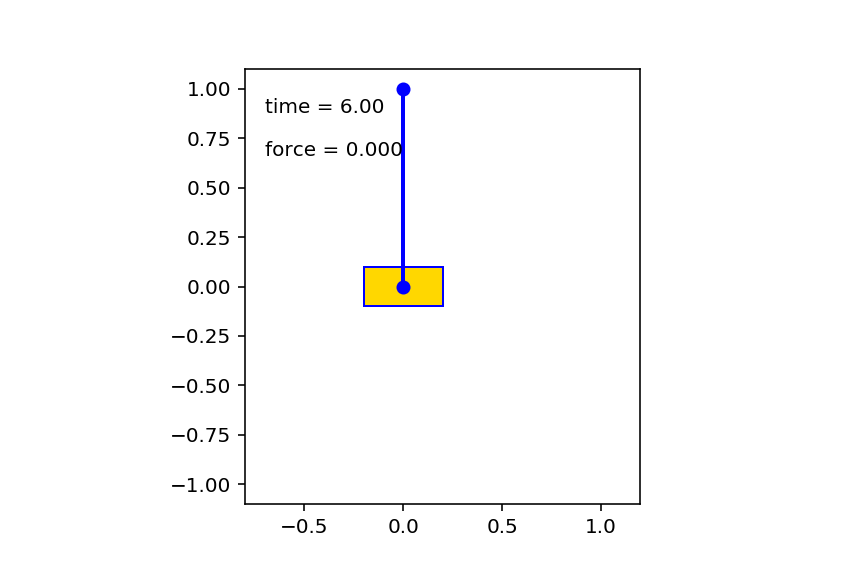

In [17]:
%matplotlib nbagg
# %matplotlib qt
anim = animate_segway(t, states, controls_final, stick_length)
anim